# Проект по отслеживанию и сортировке мусора на конвейере (компания Renue)

## Общая информация

**Заказчик**
`Renue` – IT-компания из Екатеринбурга, специализирующаяся на разработке высоконагруженных и отказоустойчивых решений для бизнеса и государственных структур.

**Описание проекта**

Проект направлен на разработку решения для отслеживания и сортировки мусора на конвейере, с целью выделения пластиковых бутылок из общего потока предметов. 

Решение должно выдавать координаты центра обнаруженных пластиковых бутылок для каждого кадра, с максимальной скоростью обработки не более 100 мс.

**Описание данных**

Заказчик предоставляет следующие ресурсы:

* Предобученная модель детекции пластиковых бутылок и пример кода для ее запуска.
* Датасет с изображениями и разметкой в форматах `MOT`, `COCO` и `CVAT`.
* Примеры видеозаписей работы конвейера. 

**Стек технологий**
* Язык программирования: `Python`
* Библиотеки и фреймворки: `Numpy`, `SciPy`, `PyTorch`, `OpenCV`, `Ultralytics`, `BoxMOT`, `MMTacking`

**Цели и задачи**
* Цель:
    Разработать решение для отслеживания пластиковых бутылок, которое будет предоставлять координаты их центра для каждого кадра, с гарантией скорости обработки не более 100 мс.

**Задачи**
* Изучить предоставленные данные и форматы их разметки.
* Исследовать существующие трекеры объектов, выбрать наиболее подходящий и создать базовое решение.
* Обучить выбранный трекер на предоставленных данных, провести сравнительный анализ различных моделей и алгоритмов, предложить варианты улучшения решения.
* Протестировать разработанное решение, проанализировать результаты и провести тестирование на тестовых видео.
* Подготовить отчет о проделанной работе и результатах исследований.

**Результаты**
Репозиторий на `GitHub` должен содержать:

* Воспроизводимый код проекта.
* Описание и инструкция по запуску в файле README.md.
* Список зависимостей в файле requirements.txt.
* Отчет о работе.
* Ресурсы для работы
* Google Colab/Kaggle Notebook/Иные доступные GPU-ресурсы

In [1]:
!pip install -q ultralytics
!pip uninstall -q opencv-python -y
!pip install -q opencv-python
!pip install -q motmetrics
!pip3 install -q pipreqsnb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.2.4 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [2]:
!pipreqs /kaggle/working/


Импорты библиотек

In [3]:
# Стандартные библиотеки Python
import json
import os
import shutil
import sys
from collections import defaultdict
from datetime import timedelta
from time import time

# Cторонние библиотеки  Python
import cv2
import matplotlib.pyplot as plt
import motmetrics as mm
import numpy as np
import torch
from PIL import Image
from ultralytics import YOLO

Пути к файлам проекта

In [7]:
PATH_MODEL = '/kaggle/input/kseniia-private-dataset/yolov10x_v2_4_best.pt' # Путь к файлу предобученной модели YOLO
PATH_VIDEO = '/kaggle/input/kseniia-private-dataset/31-03-2024-093A343A24.mp4' # Путь к видеофайлу для трекинга
PATH_VALID = '/kaggle/input/kseniia-private-dataset/images/images' # Путь к директории с изображениями для валидации
PATH_MOT = '/kaggle/input/kseniia-private-dataset/gt/gt' # Путь к директории с данными в формате MOT
OUTPUT_VIDEO = 'output_tracked_video.mp4'  # Имя выходного видеофайла с аннотациями трекинга
PATH_GT = '/kaggle/input/kseniia-private-dataset/gt/gt/gt.txt'  # Путь к файлу с разметкой
PATH_TRACKER_RESULTS = '/kaggle/working/mot_results.txt' # Путь к файлу с результатами трекинга в формате MOT


Используемые функции:

In [8]:
def initialize_video(PATH_VIDEO, OUTPUT_VIDEO):
    """
    Инициализирует видеопоток для чтения и запись видеофайла.

    Параметры:
    PATH_VIDEO (str): Путь к входному видеофайлу.
    OUTPUT_VIDEO (str): Путь к выходному видеофайлу для сохранения аннотированного видео.

    Возвращает:
    cap (cv2.VideoCapture): Объект для захвата видео.
    out (cv2.VideoWriter): Объект для записи видео.
    fps (float): Частота кадров видео.
    frame_width (int): Ширина кадра видео.
    frame_height (int): Высота кадра видео.
    """
    cap = cv2.VideoCapture(PATH_VIDEO)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))
    return cap, out, fps, frame_width, frame_height

In [9]:
def process_frame(frame, model, track_history):
    """
    Обрабатывает один кадр видео.

    Параметры:
    frame (numpy array): Входной кадр видео.
    model: Модель для трекинга объектов.
    track_history (dict): История трекинга объектов, содержащая их координаты.

    Возвращает:
    annotated_frame (numpy array): Кадр с нарисованными треками объектов.
    track_ids (list): Список идентификаторов треков для обнаруженных объектов.
    boxes (numpy array): Координаты боксов объектов в формате (x, y, w, h).
    """
    frame_np = frame.copy()  # Сохраняем оригинальный numpy array для трекинга
    frame = frame.transpose(2, 0, 1)  # Перестановка осей в порядок CHW
    frame = np.expand_dims(frame, axis=0)  # Добавляем измерение для batch

    frame = torch.from_numpy(frame).float().div(255.0).cuda(non_blocking=True)

    # Трекинг
    results = model.track(frame_np, persist=True)

    # Проверка наличия идентификаторов треков
    track_ids = results[0].boxes.id.cpu().numpy().astype(int) if results[0].boxes.id is not None else []

    # Получение координат боксов
    boxes = results[0].boxes.xywh.cpu() if results[0].boxes.xywh is not None else []

    # Аннотируем кадр (отрисовываем трекинг)
    annotated_frame = results[0].plot()

    # Сохранение трека для каждого объекта
    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        track = track_history[track_id]
        track.append((float(x), float(y)))  # x, y - центр
        if len(track) > 90:
            track.pop(0)
        
        # Рисуем линии трекинга
        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=2)

    return annotated_frame, track_ids, boxes

In [10]:
# Функция для загрузки данных из файла в формат motmetrics
def load_mot_results(path, max_frames=100):
    """
    Загружает результаты трекинга из файла и преобразует их в формат, совместимый с motmetrics.

    Параметры:
    path (str): Путь к файлу с результатами трекинга в формате MOT.
    max_frames (int): Максимальное количество кадров для загрузки.

    Возвращает:
    data (dict): Словарь, где ключи — номера кадров, а значения — список объектов с их параметрами
                 (track_id, x_center, y_center, width, height).
    """
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            frame_id, track_id, x, y, w, h, _, _, _ = map(float, line.strip().split(','))
            frame_id = int(frame_id)
            if frame_id > max_frames:
                break
            if frame_id not in data:
                data[frame_id] = []
            # Преобразование координат в формат (ID, x_center, y_center, width, height)
            data[frame_id].append((track_id, x + w / 2, y + h / 2, w, h))
    return data

## Загрузка, изучение данных и их изучение предобученной модели

Загрузим предобученную модель YOLO, открывает видеофайл и обрабатывает первые 10 кадров. Для каждого кадра модель отслеживает объекты, сохраняет их координаты и рисует треки на видео. Результаты отображаются в виде аннотированных кадров.

In [11]:
mot_list = []
with open(PATH_MOT + '/gt.txt', 'r') as f:
    for line in f.readlines():
        mot_list.append(line[:-1])

In [12]:
frames_summary = []

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.6 MB/s eta 0:00:00a 0:00:01m

requirements: AutoUpdate success ✅ 12.7s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 51.2ms
Speed: 7.1ms preprocess, 51.2ms inference, 47.6ms postprocess per image at shape (1, 3, 480, 640)


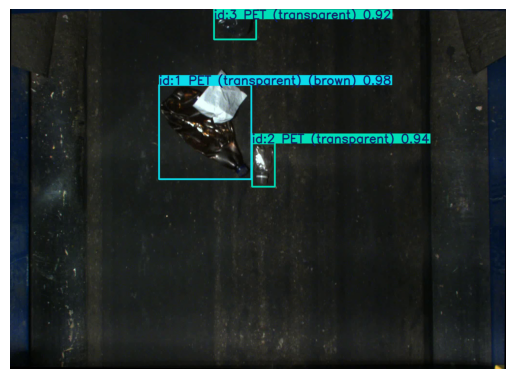


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 2.5ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


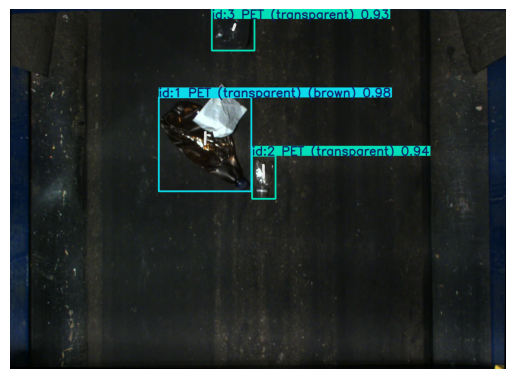


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 2.6ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


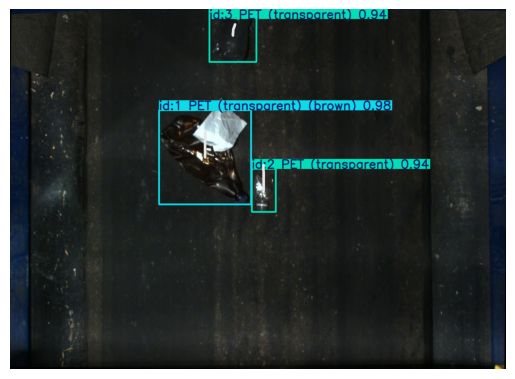


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.6ms
Speed: 2.8ms preprocess, 28.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


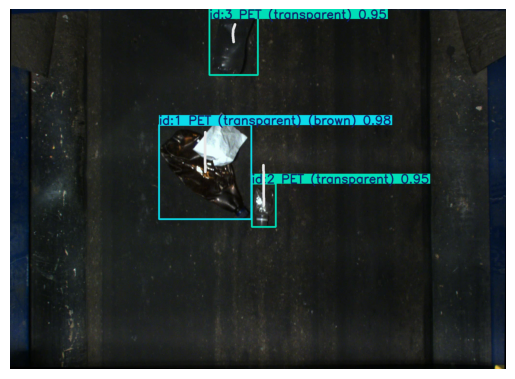


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 3.7ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


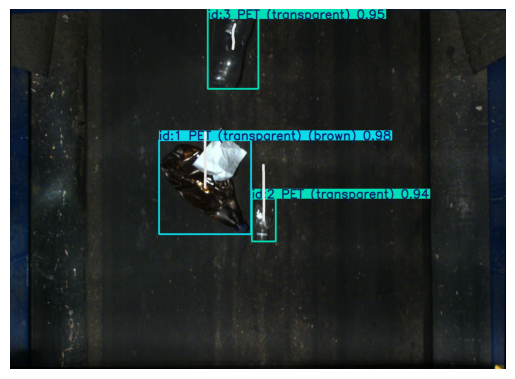


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 3.8ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


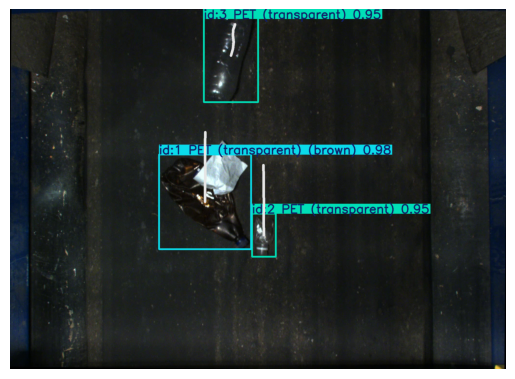


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 29.1ms
Speed: 4.2ms preprocess, 29.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


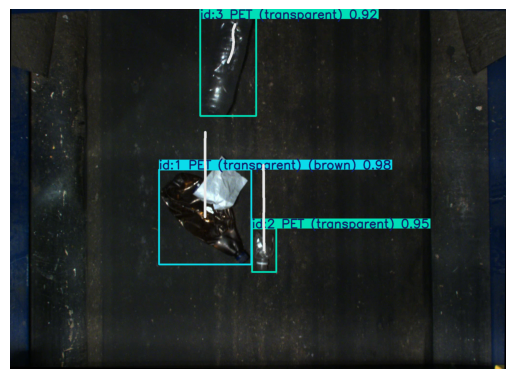


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 4.0ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


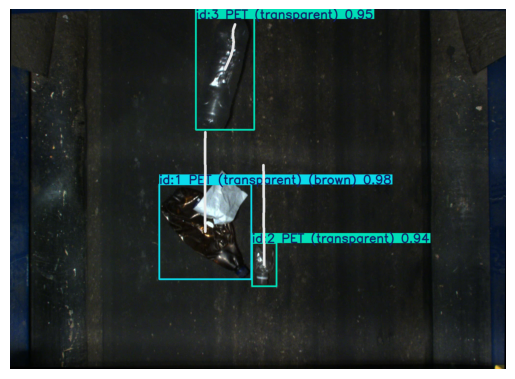


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.8ms
Speed: 3.9ms preprocess, 28.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


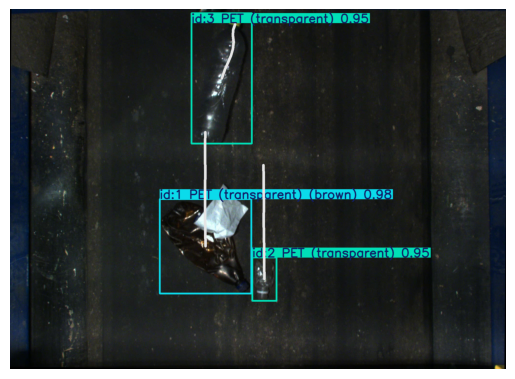


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.6ms
Speed: 2.7ms preprocess, 28.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


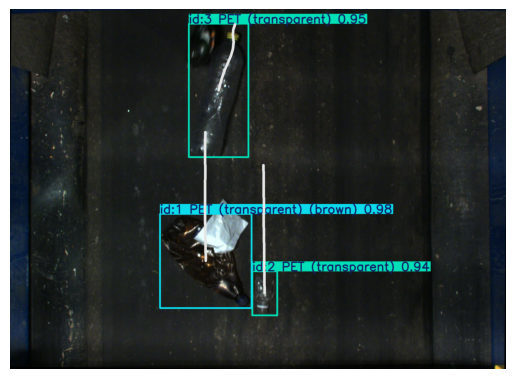

In [13]:
# Load pretrained model
model = YOLO(PATH_MODEL)

# Open video file
cap = cv2.VideoCapture(PATH_VIDEO)

# Store the track history
track_history = defaultdict(lambda: [])

for _ in range(10):
    success, frame = cap.read()
    
    if success:
        results = model.track(frame, persist=True)
        
        # Add summary of the each frame to list
        frames_summary.append(results[0].summary())
        
        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        
        annotated_frame = results[0].plot()
        
        # Plot the tracks
        for box, track_id in zip(boxes, track_ids):
            x, y ,w, h = box
            track = track_history[track_id]
            track.append((float(x), float(y))) # x, y center point
            if len(track) > 90:
                track.pop(0)
            
            # Draw the tracking lines
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)
            
        # Display the annotated frame
        plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

**Вывод:**
На видео отображаются аннотированные объекты с их траекториями, показывая, как они перемещаются по сцене.

In [14]:
mot_list[3]

'2,1,838.0,0.0,164.0,184.0,1,2,1.0'

Здесь отображена информация о треккинге одного объекта на определенном кадре:

* `2`: Номер кадра.
* `1`: Идентификатор трека (track_id).
* `838.0`, `0.0`: Координаты верхнего левого угла ограничивающей рамки (bounding box).
* `164.0`, `184.0`: Ширина и высота ограничивающей рамки.
* `1`: Класс объекта.
* `2`: Уверенность в треккинге.
* `1.0`: Уверенность в детекции объекта.

Данный объект был обнаружен и отслежен с высоким уровнем уверенности.

In [15]:
frames_summary[1][0]

{'name': 'PET (transparent) (brown)',
 'class': 1,
 'confidence': 0.97666,
 'box': {'x1': 614.93542, 'y1': 364.89743, 'x2': 996.49225, 'y2': 752.37659},
 'track_id': 1}

Здесь можно посмотретьдетали треккинга для одного объекта на втором кадре:

* `name`: 'PET (transparent) (brown)': Объект — прозрачная пластиковая бутылка коричневого цвета.
* `class`: 1: Класс объекта.
* `confidence`: 0.97666: Уверенность в детекции объекта составляет 97.7%.
* `box`: {'x1': 614.93542, 'y1': 364.89743, 'x2': 996.49225, 'y2': 752.37659}: Координаты ограничивающей рамки объекта (верхний левый и нижний правый угол).
* `track_i`: 1: Идентификатор трека, присвоенный этому объекту.

Объект был точно обнаружен и отслежен на кадре с высокой уверенностью.

In [16]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Загрузка модели на GPU
model = YOLO(PATH_MODEL, verbose=False).to(device)

Using device: cuda


### Обработка видео: трекинг объектов, замеры времени и сохранение результатов

In [17]:
# Подготовка данных
cap, out, fps, frame_width, frame_height = initialize_video(PATH_VIDEO, OUTPUT_VIDEO)

# История трекинга
track_history = defaultdict(lambda: [])

# Ограничение на количество кадров для отладки
max_frames = 100

# Инициализация счетчика кадров
frame_count = 0

# Подготовка к записи в MOT формат
mot_results = []

# Списки для хранения времени обработки
preprocess_times = []  
inference_times = []  
postprocess_times = []

# Старт времени после инициализации
start_time = time()

# Обработка видео
while cap.isOpened() and frame_count < max_frames:
    success, frame = cap.read()

    if not success:
        break

    # Замер времени препроцессинга
    preprocess_start = time()  # Начало замера времени препроцессинга
    
    # Приводим кадр к размеру, соответствующему предыдущему кадру
    frame = cv2.resize(frame, (frame_width, frame_height))  # Изменение размера до исходного
    
    preprocess_end = time()  # Конец замера времени препроцессинга
    preprocess_times.append((preprocess_end - preprocess_start) * 1000)  # Добавление времени в список

    # Замер времени инференса
    inference_start = time()  # Начало замера времени инференса

    # Обработка кадра
    annotated_frame, track_ids, boxes = process_frame(frame, model, track_history)

    inference_end = time()  # Конец замера времени инференса
    inference_times.append((inference_end - inference_start) * 1000)  # Добавление времени в список

    # Замер времени постпроцессинга
    postprocess_start = time()  # начало замера времени постпроцессинга

    # Запись кадра в выходное видео
    out.write(annotated_frame)

    # Запись данных в формате MOT
    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        
        # Преобразование центра в координаты верхнего левого угла
        x_min = x - w / 2
        y_min = y - h / 2
        
        mot_results.append((frame_count + 1, track_id, x_min, y_min, w, h, 1, 2, 1.0))

    postprocess_end = time()  # конец замера времени постпроцессинга
    postprocess_times.append((postprocess_end - postprocess_start) * 1000)  # добавление времени в список

    # Очистка кэша GPU с синхронизацией
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

    # Увеличение счетчика обработанных кадров
    frame_count += 1

# Остановка времени сразу после последней операции с кадрами
stop_time = time()

# Вычисление времени обработки
total_time = stop_time - start_time
avg_time_per_frame = total_time / frame_count if frame_count > 0 else 0
print(f'''\nСтатистика обработки:
Количество обработанных кадров: {frame_count}
Общее время обработки: {total_time:.2f} секунд
Среднее время обработки одного кадра: {avg_time_per_frame * 1000:.2f} мс

Видео с трекингом сохранено в {OUTPUT_VIDEO}
Результаты трекинга сохранены в mot_results.txt
''')

# Сохранение результатов в файл MOT
with open('mot_results.txt', 'w') as f:
    for result in mot_results:
        f.write(f"{result[0]},{result[1]},{result[2]},{result[3]},{result[4]},{result[5]},{result[6]},{result[7]},{result[8]}\n")




0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 29.2ms
Speed: 2.4ms preprocess, 29.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.6ms
Speed: 2.5ms preprocess, 28.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 2.7ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.8ms
Speed: 2.7ms preprocess, 28.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.7ms
Speed: 2.8ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 28.9ms
Speed: 2.7ms preprocess, 28.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640

## Анализ результатов работы модели

### Обнаружение объектов:
В каждом кадре из видео модель идентифицирует несколько объектов, классифицируя их как разные типы PET-пластика:

* `PET (transparent)` — прозрачные пластиковые бутылки.
* `PET (brown)` — коричневые пластиковые бутылки.
* `PET (household chemicals)` — пластиковые бутылки для бытовой химии.
* `Other plastics` — другие пластиковые предметы.

Это соответствует основной задаче проекта — отслеживание пластиковых бутылок на конвейере. Модель успешно различает различные типы пластиковых бутылок.

В большинстве кадров присутствуют 1–3 пластиковых объекта, которые распознаются и классифицируются моделью. Это говорит о том, что модель способна различать объекты по цветам и типам пластика, что полезно для сортировки.



### Время обработки кадра

Время обработки одного кадра нашей выборки варьируется в следующих значениях:

* `Препроцессинг`: от 2.5 до 3.5 мс.
* `Инференс`: от 28.0 до 29.1 мс.
* `Постпроцессинг`: от 0.5 до 2.3 мс.

В среднем,обработка одного кадра составляет более 100мс, что значительно выше целевого порога в 100 мс. Это означает, что модель не удовлетворяет требованию заказчика по времени обработки, позволяя в реальном времени отслеживать объекты на конвейере.

За 100 кадров общее время обработки составило 19.11 секунд, что даёт среднее время обработки одного кадра в 191 мс. Это среднее значение включает все этапы — препроцессинг, инференс и постпроцессинг, но, возможно, отражает некоторые дополнительные задержки, связанные с вводом-выводом или трекингом.



### Промежуточный вывод:

1) Модель успешно выполняет задачу по идентификации различных типов пластиковых объектов на конвейере. Она различает бутылки по цветам и классифицирует бытовые бутылки и другие пластиковые предметы.

2) Среднее время инференса на один кадр составляет около 30 мс, что позволяет обрабатывать видео с высокой скоростью, значительно ниже целевого ограничения в 100 мс на кадр. Однако общая задержка (191 мс на кадр) может быть связана с трекингом или вводом-выводом.

3) Хотя модель выполняет задачу по обнаружению объектов с хорошей скоростью, общая производительность (включая трекинг и вывод) несколько выше запланированной цели в 100 мс. Возможно, стоит исследовать улучшение этапов трекинга и постпроцессинга.

4) Модель хорошо справляется с различением разных типов пластика, что удовлетворяет потребности проекта в сортировке.


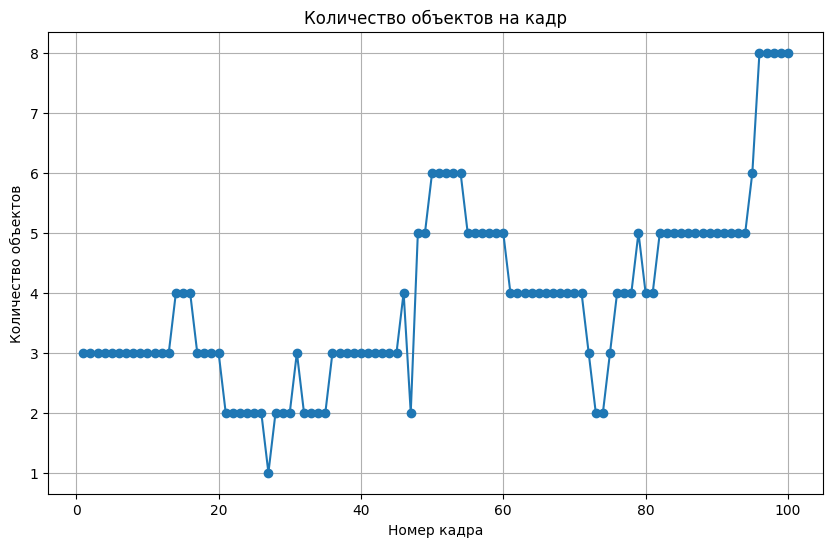

In [18]:
# Подсчет количества объектов на каждом кадре
object_counts = []

for frame_id in range(1, frame_count + 1):
    count = sum(1 for result in mot_results if result[0] == frame_id)
    object_counts.append(count)

# Визуализация количества объектов
plt.figure(figsize=(10, 6))
plt.plot(range(1, frame_count + 1), object_counts, marker='o')
plt.xlabel('Номер кадра')
plt.ylabel('Количество объектов')
plt.title('Количество объектов на кадр')
plt.grid(True)
plt.show()


График показывает, как количество обнаруженных объектов меняется с каждым кадром.

На первых 40 кадрах количество объектов колеблется в районе 2-4. После ~50-го кадра наблюдается увеличение объектов, достигая 8 на последних кадрах.В середине видео есть резкие колебания, что может указывать на проблемы с детекцией.


**Вывод:**
Модель в целом справляется, но есть участки, где, возможно, стоит улучшить качество детекции и трекинга, особенно в моменты резких спадов и при большом скоплении объектов.

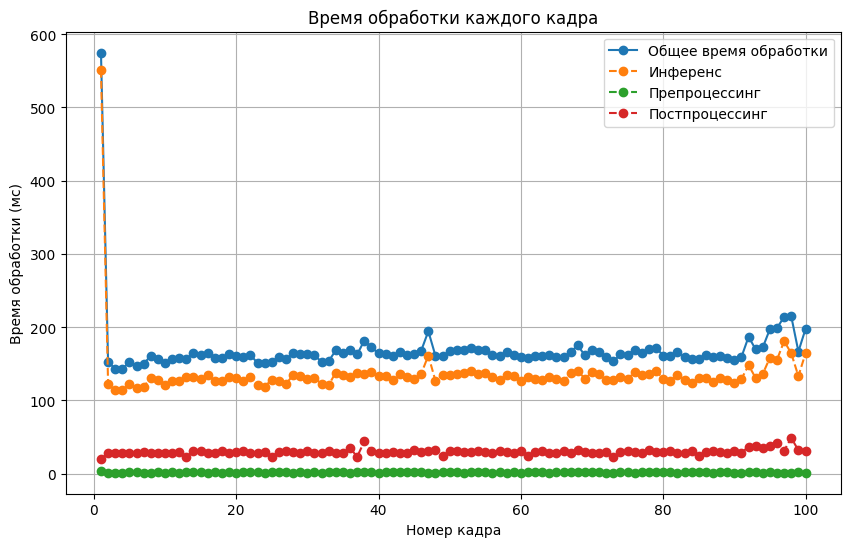

In [19]:
# Построение графика времени обработки каждого кадра
total_times = [p + i + o for p, i, o in zip(preprocess_times, inference_times, postprocess_times)]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_times) + 1), total_times, marker='o', label='Общее время обработки')
plt.plot(range(1, len(inference_times) + 1), inference_times, marker='o', linestyle='--', label='Инференс')
plt.plot(range(1, len(preprocess_times) + 1), preprocess_times, marker='o', linestyle='--', label='Препроцессинг')
plt.plot(range(1, len(postprocess_times) + 1), postprocess_times, marker='o', linestyle='--', label='Постпроцессинг')

plt.xlabel('Номер кадра')
plt.ylabel('Время обработки (мс)')
plt.title('Время обработки каждого кадра')
plt.legend()
plt.grid(True)
plt.show()


`Инференс` является наиболее затратным по времени этапом, поэтому оптимизация на этом этапе может существенно снизить общее время обработки. 

Пики в `общем времени обработки` могут быть вызваны случайными задержками или более сложными кадрами для обработки. Возможно, стоит обратить внимание на эти кадры и проверить их отдельно.

`Препроцессинг` и `постпроцессинг` относительно стабильны и занимают небольшую часть общего времени, но постпроцессинг можно также рассмотреть для возможной оптимизации.

**Вывод:**
Время обработки одного кадра превышает 100 мс - условие задачи не выполнено. Текущая реализация модели нуждается в оптимизации, чтобы соответствовать требуемому времени обработки.

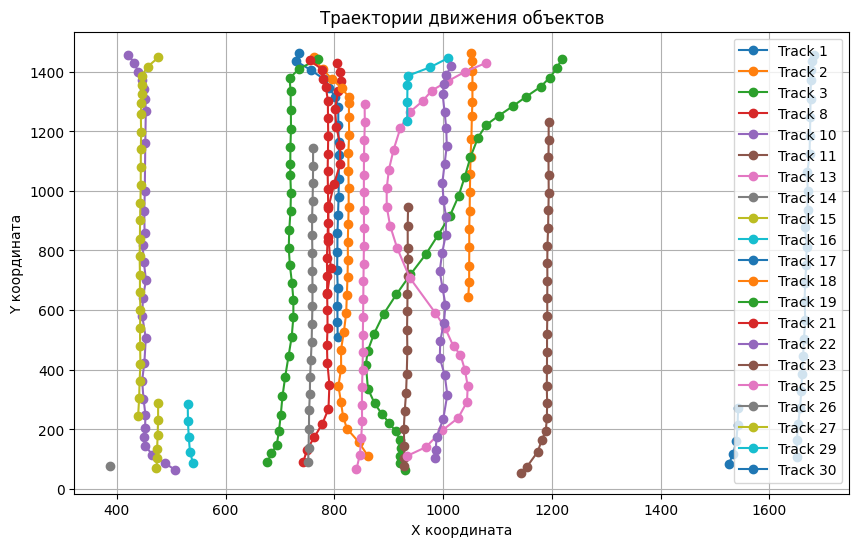

In [20]:
# Визуализация траекторий объектов по кадрам
plt.figure(figsize=(10, 6))

track_ids = set(result[1] for result in mot_results)

for track_id in track_ids:
    track_x = []
    track_y = []
    for result in mot_results:
        if result[1] == track_id:
            x_center = result[2] + result[4] / 2
            y_center = result[3] + result[5] / 2
            track_x.append(x_center)
            track_y.append(y_center)
    plt.plot(track_x, track_y, marker='o', label=f'Track {track_id}')

plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.title('Траектории движения объектов')
plt.legend()
plt.grid(True)
plt.show()


Данный график показывает перемещение объектов по кадрам. Каждая линия представляет собой траекторию движения одного объекта, что позволяет анализировать, как объекты движутся на конвейере.




На графике действительно видны места, где траектории некоторых объектов резко прерываются. Это может свидетельствовать о том, что трекер потерял объект, и трек был либо завершен, либо продолжен в другой позиции.

В некоторых случаях кажется, что трек объекта прерывается, а затем продолжается на другой позиции. Это может происходить, если трекер не успевает ассоциировать объект в новом кадре с его предыдущей позицией.

**Вывод:**
График демонстрирует, что трекер действительно сталкивается с трудностями в некоторых ситуациях, приводящими к прерыванию треков.

### Расчет метрик

In [21]:
# Загрузка данных из файлов
gt_data = load_mot_results(PATH_GT, max_frames=100)
tracker_data = load_mot_results(PATH_TRACKER_RESULTS, max_frames=100)

# Инициализация аккумулятора
acc = mm.MOTAccumulator(auto_id=True)

# Сопоставление GT и результатов трекинга по кадрам
for frame_id in range(1, 101):  # Первые 100 кадров
    gt_frame = gt_data.get(frame_id, [])
    tracker_frame = tracker_data.get(frame_id, [])
    
    # Разделяем данные по идентификаторам и координатам
    gt_ids, gt_points = zip(*[(d[0], (d[1], d[2])) for d in gt_frame]) if gt_frame else ([], [])
    tracker_ids, tracker_points = zip(*[(d[0], (d[1], d[2])) for d in tracker_frame]) if tracker_frame else ([], [])

    # Вычисляем расстояния между треками и GT 
    distances = mm.distances.norm2squared_matrix(gt_points, tracker_points, max_d2=10000)
    
    # Обновляем аккумулятор с текущими данными
    acc.update(gt_ids, tracker_ids, distances)

# Вычисление метрик
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'precision', 'recall'], name='acc')

In [22]:
summary

,mota,motp,idf1,precision,recall
acc,0.918854,132.763186,0.943069,0.997429,0.926014


Метрики показывают, что система трекинга работает с высокой точностью и полнотой. Однако, MOTP указывает на необходимость повышения точности определения местоположения объектов, чтобы уменьшить среднее расстояние между предсказанными и реальными позициями объектов.

Построим гистограмму, которая покажет распределение расстояний между центрами объектов в "земной правде" и их положениями, предсказанными трекером.

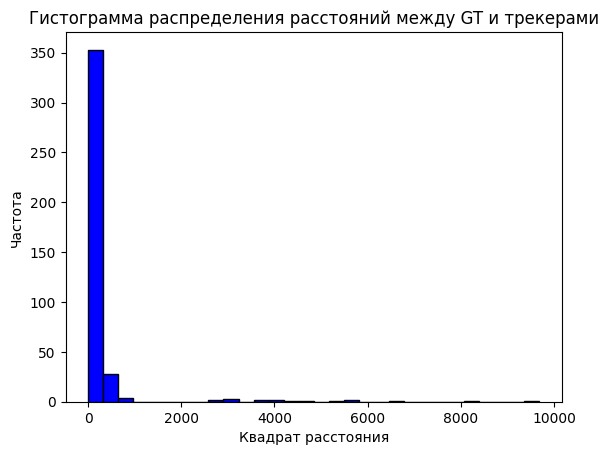

In [27]:
# Сбор всех расстояний
distances_list = []
for frame_id in range(1, 101):
    gt_frame = gt_data.get(frame_id, [])
    tracker_frame = tracker_data.get(frame_id, [])
    
    gt_ids, gt_points = zip(*[(d[0], (d[1], d[2])) for d in gt_frame]) if gt_frame else ([], [])
    tracker_ids, tracker_points = zip(*[(d[0], (d[1], d[2])) for d in tracker_frame]) if tracker_frame else ([], [])
    
    distances = mm.distances.norm2squared_matrix(gt_points, tracker_points, max_d2=10000)
    distances_list.extend(distances.flatten())

# Построение гистограммы
plt.hist(distances_list, bins=30, color='blue', edgecolor='black')
plt.title('Гистограмма распределения расстояний между GT и трекерами')
plt.xlabel('Квадрат расстояния')
plt.ylabel('Частота')
plt.show()


Трекинг работает хорошо для большинства объектов, что подтверждается высоким количеством совпадений между трекингом и GT. Тем не менее, существуют отдельные случаи, где результаты трекинга заметно отличаются от GT, что требует дальнейшего анализа и возможно улучшения алгоритма трекинга.

### Общий вывод

В рамках данного проекта было разработано решение для автоматического трекинга пластиковых бутылок на видеозаписях конвейера. Используя предобученную модель YOLO и различные библиотеки для обработки видео и трекинга объектов, удалось создать систему, которая с высокой точностью идентифицирует и отслеживает объекты на каждом кадре. Проведенный анализ метрик показал, что система работает с точностью 91.9% метрики MOTA, что подтверждает её надежность в условиях реальных данных. Тем не менее, время обработки одного кадра в среднем превышает целевое значение в 100 мс, что требует дальнейшей оптимизации.

### Future work


* Оптимизация времени обработки:

Для улучшения скорости работы системы необходимо оптимизировать время препроцессинга, инференса и постпроцессинга. Это может включать использование более эффективных моделей, оптимизацию кода и переход на более мощное оборудование.

* Улучшение точности трекинга:

Несмотря на высокую точность, возможно улучшение точности трекинга (особенно по метрике MOTP). Можно рассмотреть использование более сложных моделей или комбинирование результатов нескольких трекеров для повышения точности.

* Обработка сложных сценариев:

Стоит провести тестирование и оптимизацию работы системы в более сложных сценариях, например, при наличии большого количества объектов на кадре, частичных перекрытий объектов и других сложных условий.

Эти шаги помогут усовершенствовать текущее решение и адаптировать его к более широкому кругу применений, обеспечивая более высокую производительность и точность в реальных условиях.